In [1]:
import os
from os.path import join

import numpy as np
import pandas as pd

import tensorflow as tf
import keras
from keras import layers, Input, models

from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

2023-04-21 21:35:11.460853: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 21:35:11.904447: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-04-21 21:35:11.904485: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:
2023-04-21 21:35:11.904489: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] 

In [2]:
df = pd.read_pickle("./data/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [3]:
df.shape

(811457, 6)

In [4]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [5]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


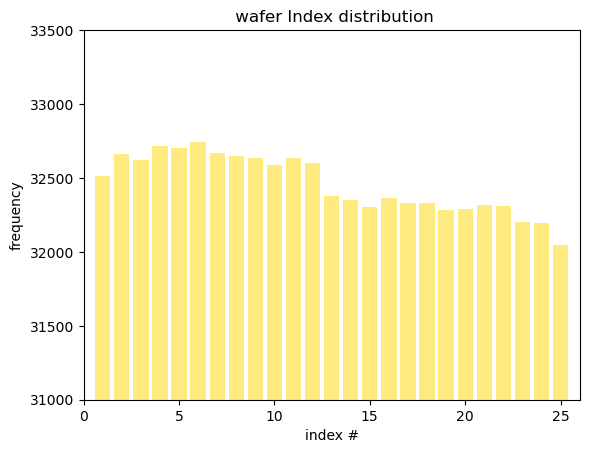

In [6]:
import matplotlib.pyplot as plt

uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(31000,33500)
plt.show()

In [8]:
df = df.drop(['waferIndex'], axis = 1)
df.shape 

In [8]:
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)

df.sample(5)

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim
124399,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4432.0,lot8255,18.0,[],[],"(75, 75)"
4328,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot175,4.0,[],[],"(26, 26)"
306696,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3814.0,lot18678,15.0,[],[],"(85, 57)"
684672,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1193.0,lot42399,20.0,[[Test]],[[none]],"(38, 40)"
582882,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot36385,14.0,[],[],"(33, 33)"


In [9]:
print(df.failureType)

0              [[none]]
1              [[none]]
2              [[none]]
3              [[none]]
4              [[none]]
              ...      
811452    [[Edge-Ring]]
811453     [[Edge-Loc]]
811454    [[Edge-Ring]]
811455               []
811456               []
Name: failureType, Length: 811457, dtype: object


In [10]:
sub_df = df.loc[df['waferMapDim'] == (26, 26)]
sub_wafer = sub_df['waferMap'].values

sw = np.ones((1, 26, 26))
label = list()

for i in range(len(sub_df)):
    # skip null label
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])

In [11]:
x = sw[1:]
y = np.array(label).reshape((-1,1))

In [12]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (14366, 26, 26), y shape : (14366, 1)


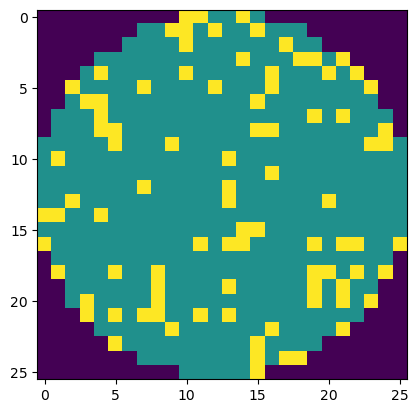

Faulty case : ['none'] 


In [13]:
plt.imshow(x[0])
plt.show()

# check faulty case
print('Faulty case : {} '.format(y[0]))

In [14]:
#add channel
x = x.reshape((-1, 26, 26, 1))

In [15]:
faulty_case = np.unique(y)
print('Faulty case list : {}'.format(faulty_case))

Faulty case list : ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [17]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 90
Donut : 1
Edge-Loc : 296
Edge-Ring : 31
Loc : 297
Near-full : 16
Random : 74
Scratch : 72
none : 13489


In [18]:
# One-hot-Encoding faulty categorical variable as channel
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j, int(x[w, i, j])] = 1

In [19]:
#check new x dimension
new_x.shape

(14366, 26, 26, 3)

In [20]:
# parameter
epoch = 30
batch_size = 1024

In [21]:
# Encoder
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)

latent_vector = layers.MaxPool2D()(encode)

# Decoder
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

# connect decoder layers
decode = decode_layer_1(latent_vector)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [22]:
ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 26, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 13, 13, 64)       36928     
 nspose)                                                         
                                                                 
 up_sampling2d (UpSampling2D  (None, 26, 26, 64)       0         
 )                                                               
                                                             

In [23]:
# start train
ae.fit(new_x, new_x,
       batch_size=batch_size,
       epochs=epoch,
       verbose=2)

Epoch 1/30
15/15 - 2s - loss: 0.1486 - 2s/epoch - 154ms/step
Epoch 2/30
15/15 - 0s - loss: 0.0926 - 285ms/epoch - 19ms/step
Epoch 3/30
15/15 - 0s - loss: 0.0801 - 285ms/epoch - 19ms/step
Epoch 4/30
15/15 - 0s - loss: 0.0692 - 284ms/epoch - 19ms/step
Epoch 5/30
15/15 - 0s - loss: 0.0613 - 284ms/epoch - 19ms/step
Epoch 6/30
15/15 - 0s - loss: 0.0554 - 286ms/epoch - 19ms/step
Epoch 7/30
15/15 - 0s - loss: 0.0505 - 288ms/epoch - 19ms/step
Epoch 8/30
15/15 - 0s - loss: 0.0460 - 285ms/epoch - 19ms/step
Epoch 9/30
15/15 - 0s - loss: 0.0414 - 285ms/epoch - 19ms/step
Epoch 10/30
15/15 - 0s - loss: 0.0369 - 288ms/epoch - 19ms/step
Epoch 11/30
15/15 - 0s - loss: 0.0328 - 285ms/epoch - 19ms/step
Epoch 12/30
15/15 - 0s - loss: 0.0293 - 287ms/epoch - 19ms/step
Epoch 13/30
15/15 - 0s - loss: 0.0263 - 284ms/epoch - 19ms/step
Epoch 14/30
15/15 - 0s - loss: 0.0238 - 286ms/epoch - 19ms/step
Epoch 15/30
15/15 - 0s - loss: 0.0218 - 288ms/epoch - 19ms/step
Epoch 16/30
15/15 - 0s - loss: 0.0202 - 286ms/epoch

In [24]:
# Make encoder model with part of autoencoder model layers
encoder = models.Model(input_tensor, latent_vector)

In [25]:
# Make decoder model with part of autoencoder model layers
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)

decoder = models.Model(decoder_input, output_tensor(decode))

In [26]:
# Encode original faulty wafer
encoded_x = encoder.predict(new_x)

449/449 [==============================] - 0s 709us/step


In [27]:
# Add noise to encoded latent faulty wafers vector.
noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64))

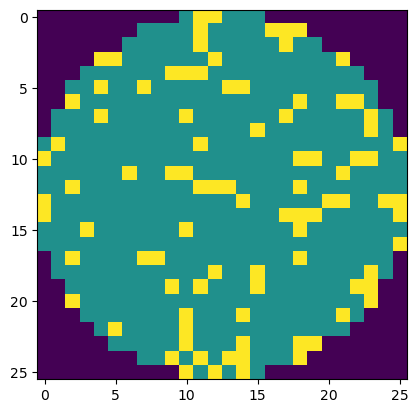

In [28]:
# check original faulty wafer data
plt.imshow(np.argmax(new_x[3], axis=2))

449/449 [==============================] - 1s 1ms/step


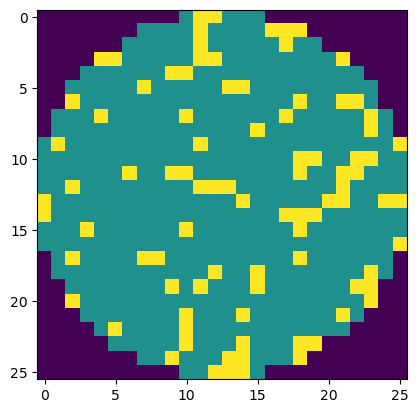

In [29]:
# check new noised faulty wafer data
noised_gen_x = np.argmax(decoder.predict(noised_encoded_x), axis=3)
plt.imshow(noised_gen_x[3])

In [30]:
# augment function define
def gen_data(wafer, label):
    # Encode input wafer
    encoded_x = encoder.predict(wafer)
    
    # dummy array for collecting noised wafer
    gen_x = np.zeros((1, 26, 26, 3))
    
    # Make wafer until total # of wafer to 2000
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)
    # also make label vector with same length
    gen_y = np.full((len(gen_x), 1), label)
    
    # return date without 1st dummy data.
    return gen_x[1:], gen_y[1:]

In [31]:
# Augmentation for all faulty case.
for f in faulty_case : 
    # skip none case
    if f == 'none' : 
        continue
    
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]], f)
    new_x = np.concatenate((new_x, gen_x), axis=0)
    y = np.concatenate((y, gen_y))

3/3 [==============================] - 0s 1ms/step


In [32]:
print('After Generate new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

After Generate new_x shape : (30707, 26, 26, 3), new_y shape : (30707, 1)


In [33]:
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 13489


In [34]:
# choice index without replace.
none_idx = np.where(y=='none')[0][np.random.choice(len(np.where(y=='none')[0]), size=11000, replace=False)]

In [35]:
# delete choiced index data.
new_x = np.delete(new_x, none_idx, axis=0)
new_y = np.delete(y, none_idx, axis=0)

In [36]:
print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (19707, 26, 26, 3), new_y shape : (19707, 1)


In [37]:
for f in faulty_case :
    print('{} : {}'.format(f, len(new_y[new_y==f])))

Center : 2160
Donut : 2002
Edge-Loc : 2368
Edge-Ring : 2046
Loc : 2376
Near-full : 2032
Random : 2146
Scratch : 2088
none : 2489


In [38]:
from tensorflow.keras.utils import to_categorical

# make string label data to numerical data
for i, l in enumerate(faulty_case):
    new_y[new_y==l] = i
    
# one-hot-encoding
new_y = to_categorical(new_y)

In [39]:
# split data train,validation, test
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,
                                                    test_size=0.2,
                                                    random_state=2022)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,
                                                    test_size=0.25,
                                                    random_state=2022)

In [40]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('val x : {}, y : {}'.format(x_val.shape, y_val.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (11823, 26, 26, 3), y : (11823, 9)
val x : (3942, 26, 26, 3), y : (3942, 9)
Test x: (3942, 26, 26, 3), y : (3942, 9)


In [41]:
from keras import backend
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense,  Dropout 
from keras.layers import AveragePooling2D, Input
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
import torch.nn as nn

In [42]:
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda
from keras import backend as K
from keras.activations import sigmoid
def cbam_block(cbam_feature, ratio=16):
    cbam_feature = channel_attention(cbam_feature, ratio)
    cbam_feature = spatial_attention(cbam_feature)
    return cbam_feature

def channel_attention(input_feature, ratio=16):
    channel_axis = 3 
    channel = input_feature.shape[channel_axis]
    print(channel)
    shared_layer_one = Dense(channel//ratio,
                             activation='relu',
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')
    shared_layer_two = Dense(channel,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

    avg_pool = GlobalAveragePooling2D()(input_feature)
    print(avg_pool.shape)
    avg_pool = Reshape((1,1,channel))(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    avg_pool = shared_layer_one(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel//ratio)
    avg_pool = shared_layer_two(avg_pool)
    assert avg_pool.shape[1:] == (1,1,channel)
    
    max_pool = GlobalMaxPooling2D()(input_feature)
    max_pool = Reshape((1,1,channel))(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    max_pool = shared_layer_one(max_pool)
    assert max_pool.shape[1:] == (1,1,channel//ratio)
    max_pool = shared_layer_two(max_pool)
    assert max_pool.shape[1:] == (1,1,channel)
    
    cbam_feature = Add()([avg_pool,max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    print(cbam_feature)
    #cbam_feature = Permute((3, 1, 2))(cbam_feature)
    
    return multiply([input_feature, cbam_feature])

def spatial_attention(input_feature):
    kernel_size = 7

    channel = input_feature.shape[1]
    cbam_feature = Permute((2,3,1))(input_feature)
    
    avg_pool = Lambda(lambda x: K.mean(x, axis=3, keepdims=True))(cbam_feature)
    assert avg_pool.shape[-1] == 1
    max_pool = Lambda(lambda x: K.max(x, axis=3, keepdims=True))(cbam_feature)
    assert max_pool.shape[-1] == 1
    concat = Concatenate(axis=3)([avg_pool, max_pool])
    assert concat.shape[-1] == 2
    cbam_feature = Conv2D(filters = 1,
                       kernel_size=kernel_size,
                       strides=1,
                       padding='same',
                       activation='sigmoid',
                       kernel_initializer='he_normal',
                       use_bias=False)(concat)	
    assert cbam_feature.shape[-1] == 1
    
    cbam_feature = Permute((3, 1, 2))(cbam_feature)

    return multiply([input_feature, cbam_feature])

In [43]:
from tensorflow.keras.models import Model
import torch

main_input = Input(shape=(26,26,3,), dtype='float32', name='main_input')
#sub1_input = torch.tensor([[96],[26],[26]])
#print(type(sub1_input))
#print(sub1_input.shape)
# 1st Convolutional Layer
x = Conv2D(filters = 96, input_shape = (26,26,3), kernel_size = (3,3), strides = (1,1), padding = 'same')(main_input)
print(x)
x_c1 = cbam_block(x)
x = Activation('relu')(x+x_c1)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'same')(x)

# 2nd Convolutional Layer
x = Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = 'same')(x)
x_c2 = cbam_block(x)
x = Activation('relu')(x+x_c2)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'same')(x)

x = Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), padding = 'same')(x)
x_c3 = cbam_block(x)
x= Activation('relu')(x+x_c3)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# 4th Convolutional Layer
x = Conv2D(filters = 384, kernel_size = (3,3), strides = (1,1), padding = 'same')(x)
x_c4 = cbam_block(x)
x = Activation('relu')(x+x_c4)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# 5th Convolutional Layer
x = Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = 'same')(x)
x_c5 = cbam_block(x)
x = Activation('relu')(x_c5)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size = (3,3), strides = (2,2), padding = 'same')(x)
Dropout(0.5)(x)

# Passing it to a dense layer
x = Flatten()(x)

# 1st Dense Layer
x = Dense(4096, input_shape = (224*224*3,))(x)
x= Activation('relu')(x)
Dropout(0.25)(x)
x = BatchNormalization()(x)

# 2nd Dense Layer
x = Dense(4096)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

# 3rd Dense Layer
x = Dense(1000)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)

# Output Layer
x = Dense(9)(x)
main_output = Activation('softmax')(x)
print(main_output)
model = Model(inputs=main_input, outputs=main_output)

KerasTensor(type_spec=TensorSpec(shape=(None, 26, 26, 96), dtype=tf.float32, name=None), name='conv2d_1/BiasAdd:0', description="created by layer 'conv2d_1'")
96
(None, 96)
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 96), dtype=tf.float32, name=None), name='activation/Sigmoid:0', description="created by layer 'activation'")
256
(None, 256)
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 256), dtype=tf.float32, name=None), name='activation_2/Sigmoid:0', description="created by layer 'activation_2'")
384
(None, 384)
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 384), dtype=tf.float32, name=None), name='activation_4/Sigmoid:0', description="created by layer 'activation_4'")
384
(None, 384)
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 384), dtype=tf.float32, name=None), name='activation_6/Sigmoid:0', description="created by layer 'activation_6'")
256
(None, 256)
KerasTensor(type_spec=TensorSpec(shape=(None, 1, 1, 256), dtype=tf.float32, name=None), name='activation

In [44]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main_input (InputLayer)        [(None, 26, 26, 3)]  0           []                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 26, 26, 96)   2688        ['main_input[0][0]']             
                                                                                                  
 global_average_pooling2d (Glob  (None, 96)          0           ['conv2d_1[0][0]']               
 alAveragePooling2D)                                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 96)          0           ['conv2d_1[0][0]']         

In [45]:
adam = Adam(learning_rate=5e-4)

In [46]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [47]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy',recall_m,precision_m,f1_m], optimizer=adam)

In [48]:
history=model.fit(x_train, y_train, batch_size=32, steps_per_epoch=len(x_train)/100, 
                    epochs=100, validation_data=(x_val, y_val))

Epoch 1/100


2023-04-21 21:40:13.841428: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


118/118 [==============================] - 11s 34ms/step - loss: 1.2821 - accuracy: 0.5659 - recall_m: 0.5055 - precision_m: 0.6455 - f1_m: 0.5650 - val_loss: 9.5692 - val_accuracy: 0.1116 - val_recall_m: 0.1109 - val_precision_m: 0.1109 - val_f1_m: 0.1109
Epoch 2/100
118/118 [==============================] - 3s 28ms/step - loss: 0.7864 - accuracy: 0.7151 - recall_m: 0.6615 - precision_m: 0.7658 - f1_m: 0.7092 - val_loss: 7.6647 - val_accuracy: 0.1116 - val_recall_m: 0.1109 - val_precision_m: 0.1109 - val_f1_m: 0.1109
Epoch 3/100
118/118 [==============================] - 3s 28ms/step - loss: 0.5700 - accuracy: 0.8086 - recall_m: 0.7778 - precision_m: 0.8349 - f1_m: 0.8048 - val_loss: 5.9054 - val_accuracy: 0.1116 - val_recall_m: 0.1109 - val_precision_m: 0.1127 - val_f1_m: 0.1118
Epoch 4/100
118/118 [==============================] - 4s 31ms/step - loss: 0.4109 - accuracy: 0.8554 - recall_m: 0.8368 - precision_m: 0.8748 - f1_m: 0.8551 - val_loss: 5.7517 - val_accuracy: 0.1116 - val_r

In [49]:
score = model.evaluate(x_test, y_test, batch_size=32)

124/124 [==============================] - 1s 8ms/step - loss: 1.4353 - accuracy: 0.9186 - recall_m: 0.9131 - precision_m: 0.9253 - f1_m: 0.9190


In [50]:
print("최종 정확도 : " + str( score[1] * 100 ) + " %" )
print("최종 재현율 : " + str( score[2] * 100 ) + " %" )
print("최종 정밀도 : " + str( score[3] * 100 ) + " %" )
print("최종 F1 socre : " + str( score[4]))

최종 정확도 : 91.8569266796112 %
최종 재현율 : 91.30544066429138 %
최종 정밀도 : 92.5284206867218 %
최종 F1 socre : 0.9190420508384705


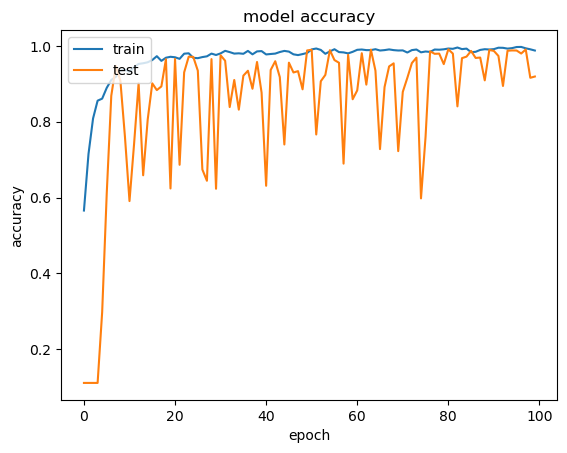

In [51]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

124/124 [==============================] - 1s 7ms/step


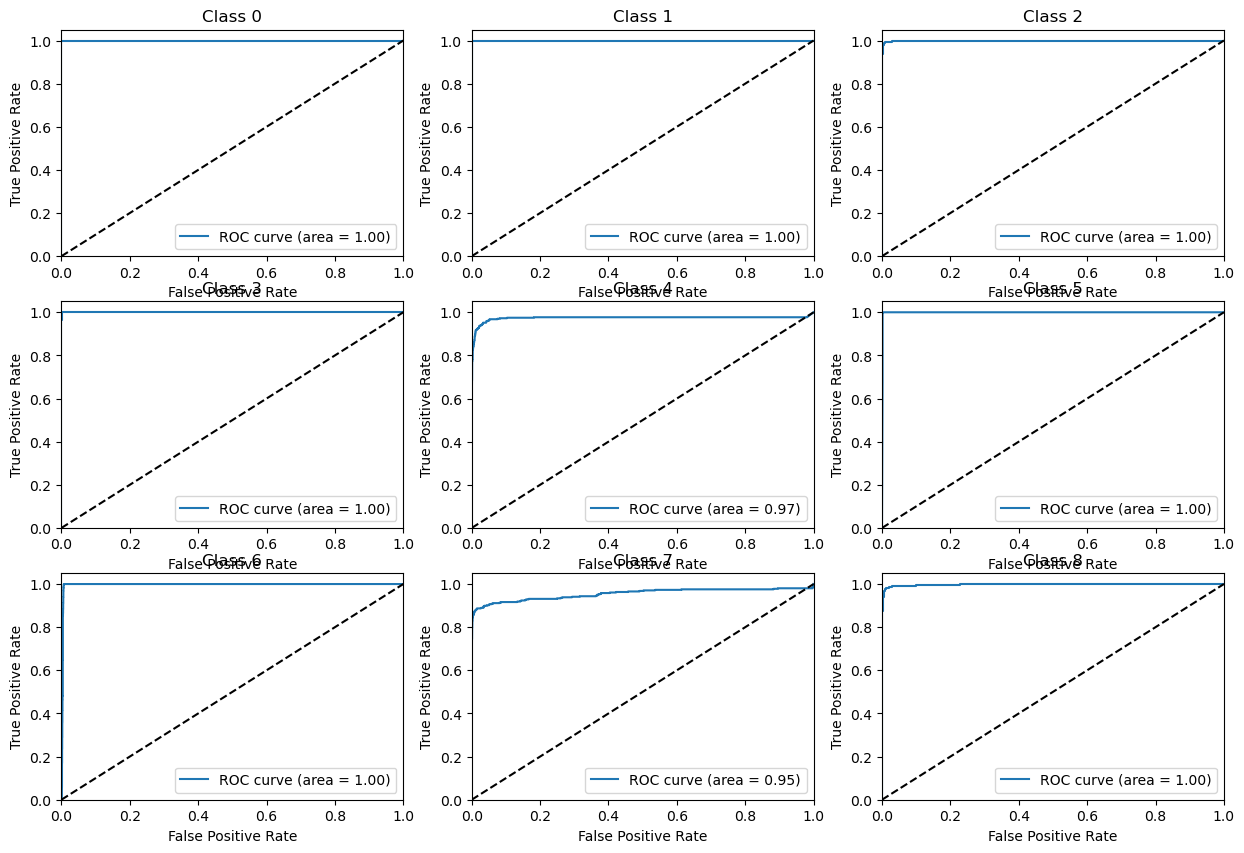

roc_auc_score:  0.9911057364706706


In [52]:
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

n_classes = 9
y_pred = model.predict(x_test)
# ROC & AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
plt.figure(figsize=(15, 10))
for idx, i in enumerate(range(n_classes)):
    plt.subplot(331+idx)
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Class %0.0f' % idx)
    plt.legend(loc="lower right")
plt.show()

print("roc_auc_score: ", roc_auc_score(y_test, y_pred, multi_class='raise'))

In [53]:
y_pred = pd.DataFrame(y_pred).T.idxmax()
yy = pd.DataFrame(y_pred)
yy.columns = ['number']
print(yy)

      number
0          4
1          7
2          2
3          4
4          2
...      ...
3937       0
3938       7
3939       6
3940       7
3941       5

[3942 rows x 1 columns]


In [54]:
yy = pd.DataFrame(yy.groupby(['number'])['number'].count())

In [55]:
yy.columns =['a']
print(yy)

          a
number     
0       460
1       397
2       485
3       394
4       497
5       470
6       479
7       468
8       292


In [56]:
cause = yy.sort_values(by ='a', ascending = False).head(1)
print(cause)

          a
number     
4       497


In [57]:
faulty_list = ['Center', 'Donut' ,'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random'
 ,'Scratch' ,'none']
print(faulty_list[8])

none


In [62]:
dim2 = pd.DataFrame(dim1.groupby(['waferMapDim'])['waferMapDim'].count())
dim2.columns = ['count']
cause = dim2.sort_values (by = 'count', ascending = False).head(1)
faulty_list = ['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']
print(faulty_list[cause])

NameError: name 'dim1' is not defined

In [63]:
import numpy as np
from sklearn.metrics import (confusion_matrix, accuracy_score,
                             recall_score, precision_score, f1_score)
import matplotlib.pyplot as plt


# confusion matrix 그리는 함수
def plot_confusion_matrix(
        y_pred, y_true, labels,             # 예측값, 실측값, labels = classnames
        title='Confusion Matrix',           # 그래프 제목
        cmap=plt.cm.Blues,                  # plt.cm.get_cmap('Blues') (old version)
        normalize=False,                    # percentage로 표현
        norm_on_model=False):               # 정규화 시 예측값 기준으로 계산

    if normalize:
        if norm_on_model:
            cm = confusion_matrix(y_true, y_pred, normalize='pred')    # ndarray, x축 (y_pred), y축 (y_true)
        else:
            cm = confusion_matrix(y_true, y_pred, normalize='true')    # ndarray, x축 (y_pred), y축 (y_true)
    else:
        cm = confusion_matrix(y_true, y_pred)
    thresh = cm.max() / 2.

    plt.imshow(cm, cmap=cmap)      # interpolation='nearest'
    plt.title(title)
    plt.colorbar()

    con_mat = confusion_matrix(y_true, y_pred)

    ticks = np.arange(len(labels))  # 눈금
    plt.xticks(ticks, labels, rotation=45)
    plt.yticks(ticks, labels, rotation=0, ha='right')         # va : vertical alignment

    if normalize:
        if norm_on_model:  # 모델의 예측값(column)을 기준으로 정규화
            n = con_mat.sum(0)
            for i in range(con_mat.shape[0]):
                for j in range(con_mat.shape[1]):
                    plt.text(j, i, '{:.1f}%'.format(
                        con_mat[i, j] * 100 / n[j]), ha="center", color="w" if cm[i, j] > thresh else "k")
        else:   # 데이터의 참값(row)을 기준으로 정규화
            n = con_mat.sum(1)
            for i in range(con_mat.shape[0]):
                for j in range(con_mat.shape[1]):
                    plt.text(j, i, '{:.1f}%'.format(
                        con_mat[i, j] * 100 / n[i]), ha="center", color="w" if cm[i, j] > thresh else "k")

    else:
        for i in range(con_mat.shape[0]):
            for j in range(con_mat.shape[1]):
                plt.text(j, i, con_mat[i, j], ha="center", va='center', color="w" if cm[i, j] > thresh else "k")

    # plt.tight_layout()
    plt.xlabel('Predicted label', fontsize=12)
    plt.ylabel('Actual label', fontsize=12)
    plt.tight_layout()
    plt.show()


def calculate_cm_metrics(y_pred, y_true):
    # Confusion Matrix 계산
    cm = confusion_matrix(y_true, y_pred)   # 매개변수 순서 : y축, x축

    # 클래스별 TP, FN, FP, TN 값 계산
    n = cm.shape[0]
    precision = np.zeros(n)
    recall = np.zeros(n)
    f1_score = np.zeros(n)
    for i in range(n):
        tp = tp = cm[i, i]
        fn = cm[i].sum() - tp
        fp = cm[:, i].sum() - tp
        tn = cm.sum() - tp - fn - fp

        precision[i] = tp / (tp + fp)
        recall[i] = tp / (tp + fn)
        f1_score[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])

    return accuracy_score(y_pred, y_true), precision, recall, f1_score

[[3 0 0]
 [0 1 2]
 [2 1 3]]
Accuracy = 0.58
Precision = 0.60
Recall = 1.00
f1-score = 0.75

scikit-learn
Accuracy = 0.58
Precision = 0.60
Recall = 1.00
F1-score = 0.75


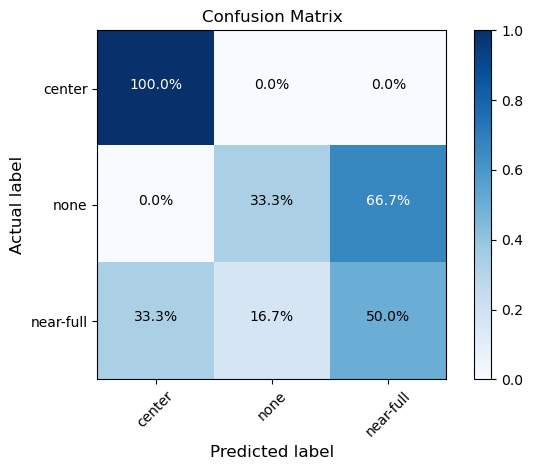

In [64]:
# 정답/예측 데이터 생성
y_true = [2, 0, 2, 2, 0, 1, 1, 2, 2, 0, 1, 2]
y_pred = [0, 0, 2, 1, 0, 2, 1, 0, 2, 0, 2, 2]

# 혼동행렬 생성 및 평가지표 계산
conf_mat = confusion_matrix(y_true, y_pred) # 인자 순서 : y축, x축
print(conf_mat)

acc, prc, rcl, f1 = calculate_cm_metrics(y_pred, y_true)
print('Accuracy = {:.2f}'.format(acc))
print('Precision = {:.2f}'.format(prc[0]))
print('Recall = {:.2f}'.format(rcl[0]))
print('f1-score = {:.2f}'.format(f1[0]))

# scikit-learn 활용
print('\nscikit-learn')
print('Accuracy = {:.2f}'.format(accuracy_score(y_true, y_pred)))
print('Precision = {:.2f}'.format(precision_score(y_true, y_pred, average=None)[0]))
print('Recall = {:.2f}'.format(recall_score(y_true, y_pred, average=None)[0]))
print('F1-score = {:.2f}'.format(f1_score(y_true, y_pred, average=None)[0]))

# 라벨 설정
labels = ['center', 'none', 'near-full']
plot_confusion_matrix(y_pred, y_true, labels, normalize=True, norm_on_model=False)